In [5]:
import sys
sys.path.insert(0, '../../')

import graph
import importlib
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import schedule as sch
import topo
import typing
import utils
import yaml
from tqdm.notebook import tqdm

matplotlib.rc('font', family='Times New Roman', size=16)

In [6]:
def unit_size_cb(r: int):
    return 10000 * math.pow(10, random.randint(0, 1))

def gen_graphs(graph_count, source_selector_dict, max_source_num):
    source_selector = graph.MultiDomainSourceSelector(source_selector_dict)
    global source_quota
    source_quota = max_source_num
    def source_num(i):
        global source_quota
        assert graph_count - i <= source_quota
        delta = source_quota - (graph_count - i)
        ret = 1 + random.randint(0, min(delta, 2))
        source_quota -= ret
        return ret
    gen_args_list = [
            {
            "total_rank": random.randint(3, 7),
            "max_node_per_rank": random.randint(1, 3),
            "max_predecessors": random.randint(1, 2),
            "mi_cb": lambda: 1,
            "memory_cb": lambda: int(2e8),
            "unit_size_cb": unit_size_cb,
            "unit_rate_cb": lambda: random.randint(10, 20),
            "source_hosts": source_selector,
            "sink_hosts": ["cloud1"],
            "sources_num": source_num(i),
        }
        for i in range(graph_count)
    ]
    return [
        graph.MultiSourceGraphGenerator("g" + str(idx), **gen_args).gen_dag_graph()
        for idx, gen_args in enumerate(gen_args_list)
    ]

In [7]:
from tqdm.notebook import trange

def big_avg(array):
    return sum(array) / len(array)

def run(sc, labels, source_selector_dict, max_source_num,
        run_sbon: bool = True):
    flow_bp_data = [[] for _ in labels]
    all_cloud_bp_data = [[] for _ in labels]
    sbon_bp_data = [[] for _ in labels]
    flow_event_data = [[] for _ in labels]
    all_cloud_event_data = [[] for _ in labels]
    sbon_event_data = [[] for _ in labels]
    edge_random_event_data = [[] for _ in labels]
    test_round = 100
    for idx, graph_count in enumerate(labels):
        print(graph_count)
        for _ in trange(test_round, desc="running with {} graphs".format(graph_count)):
            graph_list = gen_graphs(graph_count, source_selector_dict, max_source_num)
            sc.topo.clear_occupied()
            flow_scheduler = sch.MultiEdgeFlowScheduler(sc)
            flow_calculator = sch.LatencyCalculator(sc.topo)
            flow_result_list = flow_scheduler.schedule_multiple(graph_list)
            for g, result in zip(graph_list, flow_result_list):
                assert result is not None
                flow_calculator.add_scheduled_graph(g, result)
            flow_latency, flow_bp, _ = flow_calculator.compute_latency()
            for g in graph_list:
                flow_event_data[idx].append(flow_latency[g.uuid] / g.number_of_vertices())
                flow_bp_data[idx].append(flow_bp[g.uuid])

            if run_sbon:
                sc.topo.clear_occupied()
                sbon_scheduler = sch.MultiEdgeSbonScheduler(sc)
                sbon_calculator = sch.LatencyCalculator(sc.topo)
                sbon_result_list = sbon_scheduler.schedule_multiple(graph_list)
                for g, result in zip(graph_list, sbon_result_list):
                    assert result is not None
                    sbon_calculator.add_scheduled_graph(g, result)
                sbon_latency, sbon_bp, _ = sbon_calculator.compute_latency()
                for g in graph_list:
                    sbon_event_data[idx].append(sbon_latency[g.uuid] / g.number_of_vertices())
                    sbon_bp_data[idx].append(sbon_bp[g.uuid])

            sc.topo.clear_occupied()
            all_cloud_scheduler = sch.MultiEdgeAllCloudScheduler(sc)
            all_cloud_calculator = sch.LatencyCalculator(sc.topo)
            all_cloud_result_list = all_cloud_scheduler.schedule_multiple(graph_list)
            for g, result in zip(graph_list, all_cloud_result_list):
                assert result is not None
                all_cloud_calculator.add_scheduled_graph(g, result)
            all_cloud_latency, all_cloud_bp, _ = all_cloud_calculator.compute_latency()
            for g in graph_list:
                all_cloud_event_data[idx].append(all_cloud_latency[g.uuid] / g.number_of_vertices())
                all_cloud_bp_data[idx].append(all_cloud_bp[g.uuid])
            # all_cloud_event_data[idx].extend(list(all_cloud_latency.values()))

            # sc.topo.clear_occupied()
            # edge_random_scheduler = sch.EdgeRandomScheduler(sc)
            # edge_random_calculator = sch.LatencyCalculator(sc.topo)
            # edge_random_result_list = edge_random_scheduler.schedule_multiple(graph_list)
            # for g, result in zip(graph_list, edge_random_result_list):
            #     assert result is not None
            #     edge_random_calculator.add_scheduled_graph(g, result)
            # edge_random_latency, edge_random_bp = edge_random_calculator.compute_latency()
            # edge_random_event_data[idx].extend(list(edge_random_latency.values()))

            # for k in all_cloud_latency.keys():
                # flow_event_data[idx].append(flow_latency[k] / all_cloud_latency[k])
                # edge_random_event_data[idx].append(edge_random_latency[k] / flow_latency[k])
    flow_event_data = [big_avg(i) for i in flow_event_data]
    flow_bp_data = [big_avg(i) for i in flow_bp_data]
    all_cloud_event_data = [big_avg(i) for i in all_cloud_event_data]
    all_cloud_bp_data = [big_avg(i) for i in all_cloud_bp_data]
    if run_sbon:
        sbon_event_data = [big_avg(i) for i in sbon_event_data]
        sbon_bp_data = [big_avg(i) for i in sbon_bp_data]
    # return flow_event_data, flow_bp_data, all_cloud_event_data, all_cloud_bp_data, sbon_event_data, sbon_bp_data
    return flow_event_data, flow_bp_data, all_cloud_event_data, all_cloud_bp_data, sbon_event_data, sbon_bp_data
    # ax_lat.plot(flow_event_data)
    # ax_lat.plot(all_cloud_event_data)
    # ax_bp.plot(flow_bp_data)
    # ax_bp.plot(all_cloud_bp_data)
    # plt.eventplot(flow_event_data, lineoffsets=[i-width for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C0", orientation="vertical")
    # plt.eventplot(edge_random_event_data, lineoffsets=[i for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C1", orientation="vertical")
    # plt.eventplot(all_cloud_event_data, lineoffsets=[i+width for i in range(len(labels))], linelengths=width, linewidths=0.5, colors="C2", orientation="vertical")
    # plt.violinplot(flow_event_data, vert=True, positions=[i-width for i in range(len(labels))], widths=width)
    # plt.violinplot(edge_random_event_data, vert=True, positions=[i for i in range(len(labels))], widths=width)
    # plt.violinplot(all_cloud_event_data, vert=True, positions=[i+width for i in range(len(labels))], widths=width)

In [8]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e6h.yaml", "r").read(), Loader=yaml.Loader))
f_lat1, f_bp1, ac_lat1, ac_bp1, sbon_lat1, sbon_bp1 = run(sc, [4, 8, 12, 16, 20], 
                    {"edge0": {'e0rasp1': 10, 'e0rasp2': 10, 'e0rasp3': 10},
                    "edge1": {'e1rasp1': 10, 'e1rasp2': 10, 'e1rasp3': 10}}, 45)
print(f_lat1)
print(ac_lat1)
print(sbon_lat1)

4


running with 4 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[('e1rasp3', 3), ('e1rasp2', 4), ('e1rasp_switch', 0), ('e1rasp1', 1), ('edge1_router', 0)]
[('e0rasp1', 1), ('e0rasp3', 0), ('edge0_router', 0), ('e0rasp2', 1), ('e0rasp_switch', 0)]
[('cloud_switch', 0), ('cloud0_router', 0), ('cloud1', 21)]
[('e0rasp1', 7), ('e0rasp3', 2), ('edge0_router', 0), ('e0rasp2', 1), ('e0rasp_switch', 0)]
[('e1rasp3', 6), ('e1rasp2', 0), ('e1rasp_switch', 0), ('e1rasp1', 2), ('edge1_router', 0)]
[('cloud_switch', 0), ('cloud0_router', 0), ('cloud1', 21)]
[('e0rasp1', 2), ('e0rasp3', 1), ('edge0_router', 0), ('e0rasp2', 1), ('e0rasp_switch', 0)]
[('e1rasp3', 1), ('e1rasp2', 5), ('e1rasp_switch', 0), ('e1rasp1', 4), ('edge1_router', 0)]
[('cloud_switch', 0), ('cloud0_router', 0), ('cloud1', 19)]
[('e1rasp3', 1), ('e1rasp2', 0), ('e1rasp_switch', 0), ('e1rasp1', 3), ('edge1_router', 0)]
[('e0rasp1', 2), ('e0rasp3', 4), ('edge0_router', 0), ('e0rasp2', 1), ('e0rasp_switch', 0)]
[('cloud_switch', 0), ('cloud0_router', 0), ('cloud1', 22)]
[('e0rasp1', 0), ('e0ras

KeyboardInterrupt: 

In [5]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e18h.yaml", "r").read(), Loader=yaml.Loader))
edge0 = {"e0rasp"+str(i): 12 for i in range(1, 7)}
edge1 = {"e1rasp"+str(i): 12 for i in range(1, 4)}
edge1.update({"e1vm"+str(i): 24 for i in range(1, 4)})
edge2 = {"e2rasp"+str(i): 12 for i in range(1, 5)}
edge2.update({"e2vm"+str(i): 24 for i in range(1, 3)})
source_dict = {"edge0": edge0, "edge1": edge1, "edge2": edge2}
f_lat2, f_bp2, ac_lat2, ac_bp2, sbon_lat2, sbon_bp2 = run(sc, [40, 60, 80, 100, 120], source_dict, 200)
print(f_lat2)
print(ac_lat2)
print(sbon_lat2)

40


running with 40 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

60


running with 60 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

80


running with 80 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

100


running with 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

120


running with 120 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[8.396175984219992, 10.578917898916153, 12.721444187322792, 15.250777408988306, 17.33842337557874]
[9.243942705596366, 11.847954734663158, 14.202070948650883, 17.103994659016738, 19.71216467813423]
[14.1337895553598, 17.122743036583085, 15.977190462216488, 16.523187301858336, 18.37282425688944]


In [6]:
sc = topo.Scenario.from_dict(yaml.load(open("../../samples/1e54h.yaml", "r").read(), Loader=yaml.Loader))
edge0 = {"e0rasp"+str(i): 12 for i in range(1, 9)}
edge0.update({"e0vm"+str(i): 24 for i in range(1, 7)})
edge0.update({"e0desktop"+str(i): 48 for i in range(1, 5)})
edge1 = {"e1rasp"+str(i): 12 for i in range(1, 9)}
edge1.update({"e1vm"+str(i): 24 for i in range(1, 7)})
edge1.update({"e1desktop"+str(i): 48 for i in range(1, 5)})
edge2 = {"e2rasp"+str(i): 12 for i in range(1, 9)}
edge2.update({"e2vm"+str(i): 24 for i in range(1, 7)})
edge2.update({"e2desktop"+str(i): 48 for i in range(1, 5)})
source_dict = {"edge0": edge0, "edge1": edge1, "edge2": edge2}
f_lat3, f_bp3, ac_lat3, ac_bp3, _, _ = run(sc, [200, 300, 400, 500, 600], source_dict, 1000, False)
print(f_lat3, ac_lat3)

200


running with 200 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

300


running with 300 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

400


running with 400 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

500


running with 500 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

600


running with 600 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

[20.463923900487114, 28.873667504868862, 38.02278311848364, 46.204648623736816, 54.298475132351456] [24.158555301804352, 34.594546343689984, 44.72650314566338, 54.69555078973116, 65.05225963186567]


In [8]:
import json
data = {
    "f_lat1": f_lat1,
    "f_lat2": f_lat2,
    "f_lat3": f_lat3,
    "ac_lat1": ac_lat1,
    "ac_lat2": ac_lat2,
    "ac_lat3": ac_lat3,
    "sbon_lat1": sbon_lat1,
    "sbon_lat2": sbon_lat2,
    "f_bp1": f_bp1,
    "f_bp2": f_bp2,
    "f_bp3": f_bp3,
    "ac_bp1": ac_bp1,
    "ac_bp2": ac_bp2,
    "ac_bp3": ac_bp3,
    "sbon_bp1": sbon_bp1,
    "sbon_bp2": sbon_bp2,
}
with open("lat_exp.json", "w") as f:
    f.write(json.dumps(data))

In [1]:
import json
with open("lat_exp.json", "r") as f:
    data = json.loads(f.read())
    f_lat1 = data["f_lat1"]
    f_lat2 = data["f_lat2"]
    f_lat3 = data["f_lat3"]
    ac_lat1 = data["ac_lat1"]
    ac_lat2 = data["ac_lat2"]
    ac_lat3 = data["ac_lat3"]
    sbon_lat1 = data["sbon_lat1"]
    sbon_lat2 = data["sbon_lat2"]


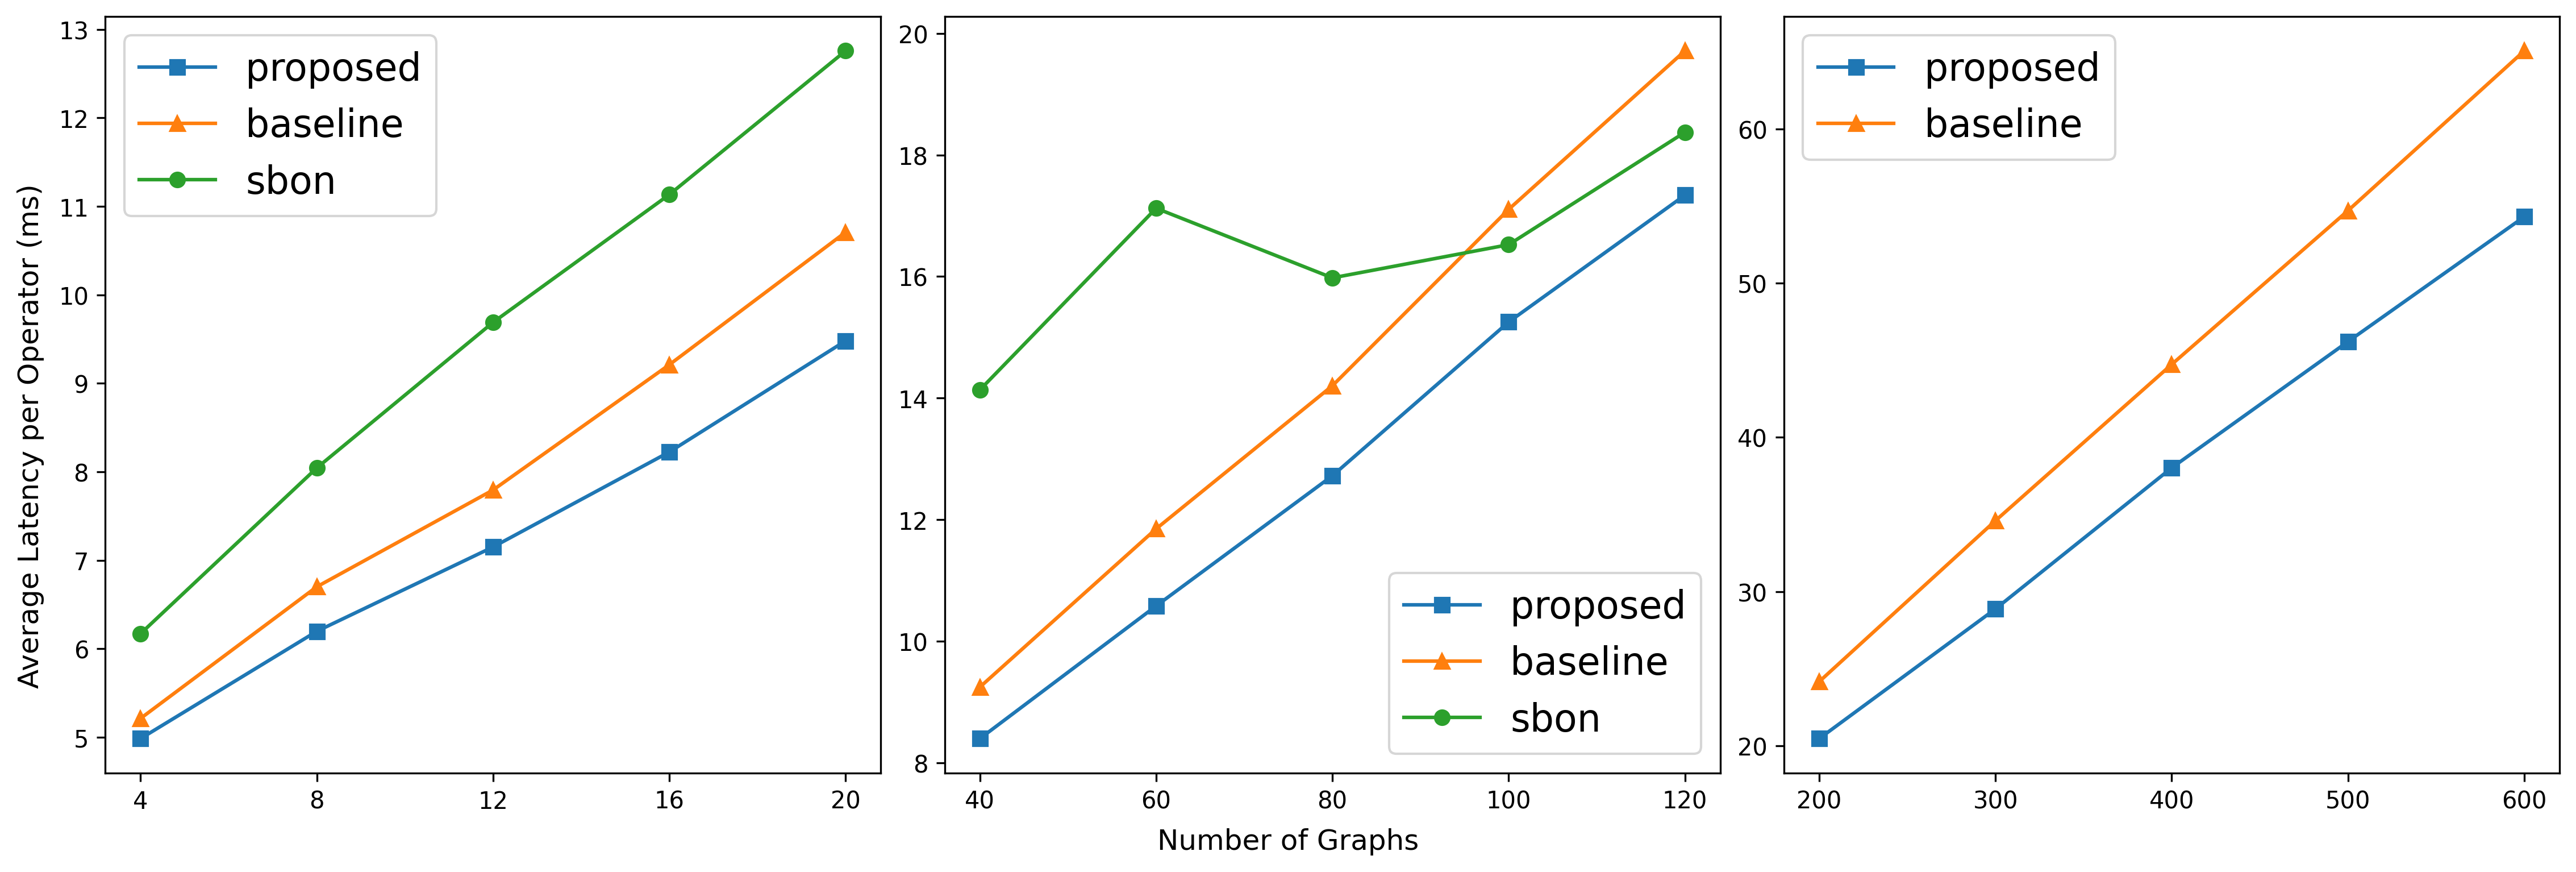

In [4]:
import matplotlib
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300, constrained_layout=True)
fig.supxlabel("Number of Graphs")
fig.supylabel("Average Latency per Operator (ms)")
axes[0].set_xticks([i for i in range(5)])
axes[0].set_xticklabels([4, 8, 12, 16, 20])
axes[1].set_xticks([i for i in range(5)])
axes[1].set_xticklabels([40, 60, 80, 100, 120])
axes[2].set_xticks([i for i in range(5)])
axes[2].set_xticklabels([200, 300, 400, 500, 600])
f_line1, = axes[0].plot(f_lat1, marker="s")
ac_line1, = axes[0].plot(ac_lat1, marker="^")
sbon_line1, = axes[0].plot(sbon_lat1, marker="o")
axes[0].legend([f_line1, ac_line1, sbon_line1], ["proposed", "baseline", "sbon"], prop={"size": "16"})
f_line2, = axes[1].plot(f_lat2, marker="s")
ac_line2, = axes[1].plot(ac_lat2, marker="^")
sbon_line2, = axes[1].plot(sbon_lat2, marker="o")
axes[1].legend([f_line2, ac_line2, sbon_line2], ["proposed", "baseline", "sbon"], prop={"size": "16"})
f_line3, = axes[2].plot(f_lat3, marker="s")
ac_line3, = axes[2].plot(ac_lat3, marker="^")
axes[2].legend([f_line3, ac_line3], ["proposed", "baseline"], prop={"size": "16"})
plt.show()